In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [96]:
data = pd.read_csv('bio copy.csv')
gender = {
    "M":1,
    "F":0
}
data["Gender"] = data["Gender"].map(gender)
data.dropna(inplace=True)
X = data[["Age","Gender","BMI","Body weight ","Height "]].values
y = data["Insulin "].values.reshape(-1, 1)

In [97]:
#df = pd.read_csv('stuff copy.csv')

#X = df[['Age', 'Gender', 'BMI', 'Body weight ', 'Height ']].values
#y = df['HOMA-IR'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

In [102]:
class RegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(x)

model = RegressionNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Training loop
epochs = 1000

Epoch [1/1000], Loss: 0.9339, Val Loss: 1.4720
Epoch [2/1000], Loss: 0.8620, Val Loss: 1.3977
Epoch [3/1000], Loss: 0.7934, Val Loss: 1.3286
Epoch [4/1000], Loss: 0.7299, Val Loss: 1.2649
Epoch [5/1000], Loss: 0.6687, Val Loss: 1.1999
Epoch [6/1000], Loss: 0.6113, Val Loss: 1.1363
Epoch [7/1000], Loss: 0.5589, Val Loss: 1.0770
Epoch [8/1000], Loss: 0.5122, Val Loss: 1.0253
Epoch [9/1000], Loss: 0.4715, Val Loss: 0.9852
Epoch [10/1000], Loss: 0.4387, Val Loss: 0.9607
Epoch [11/1000], Loss: 0.4152, Val Loss: 0.9465
Epoch [12/1000], Loss: 0.4022, Val Loss: 0.9416
Epoch [13/1000], Loss: 0.3995, Val Loss: 0.9405
Epoch [14/1000], Loss: 0.4026, Val Loss: 0.9392
Epoch [15/1000], Loss: 0.4065, Val Loss: 0.9363
Epoch [16/1000], Loss: 0.4069, Val Loss: 0.9311
Epoch [17/1000], Loss: 0.4013, Val Loss: 0.9249
Epoch [18/1000], Loss: 0.3895, Val Loss: 0.9194
Epoch [19/1000], Loss: 0.3745, Val Loss: 0.9166
Epoch [20/1000], Loss: 0.3581, Val Loss: 0.9169
Epoch [21/1000], Loss: 0.3432, Val Loss: 0.9220
E

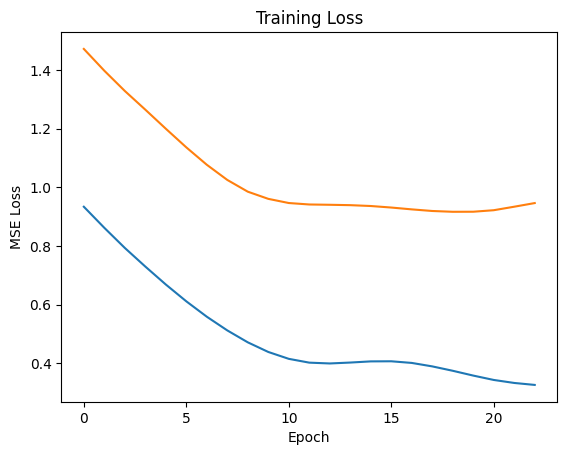

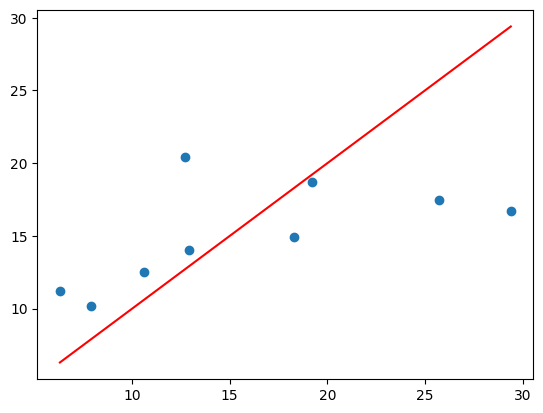

R² value: 0.3285


In [103]:
best_model_state = None

losses = []
val_losses = []
best_loss = float('inf')
patience = 4
trigger_times = 0
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    
    val_loss = criterion(model(X_test_tensor), y_test_tensor).item()
    val_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model)
            break

plt.plot(losses)
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.show()

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    predictions = y_scaler.inverse_transform(predictions)
    y_true = y_scaler.inverse_transform(y_test_tensor.numpy())

# Plot predictions vs actual
plt.scatter(y_true, predictions)

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
plt.show()

r2 = r2_score(y_true, predictions)
print(f"R² value: {r2:.4f}")
torch.save(best_model_state, 'model.pth')


In [29]:
model.load_state_dict(torch.load("model.pth"))
model.eval()


TypeError: Expected state_dict to be dict-like, got <class 'NoneType'>.